In [1]:
import os
import random

from res_unet import SiameseNetwork
from PIL import Image
from tqdm.notebook import tqdm
from kornia.losses import DiceLoss
from losses import ContrastiveLoss
from utils import *
from datasets import MadoriOutlineDS, MadoriOutlineSiameseDS

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import functional as TF
from torch.nn import functional as F
from torch.nn import Module
from torch.optim import Adam

from matplotlib import pyplot as plt
%matplotlib inline

### global variables

In [2]:
img_dir = './data/image'
label_dir = './data/outline'
pair_madori_dir = './data/pair_madori'
checkpoint_dir = './checkpoint'

batch_size = 4
num_epochs = 100

train_file = './data/train.txt'
val_file = './data/val.txt'
test_file = './data/test.txt'
pair_madori_file = './data/pair_madori.txt'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### data loaders

In [3]:
train_dl = DataLoader(MadoriOutlineSiameseDS(train_file), batch_size=batch_size, shuffle=True)
val_dl = DataLoader(MadoriOutlineSiameseDS(val_file), batch_size=batch_size, shuffle=True)

tensor([1.])


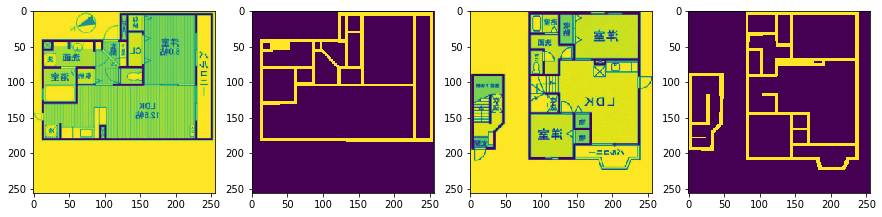

tensor([0.])


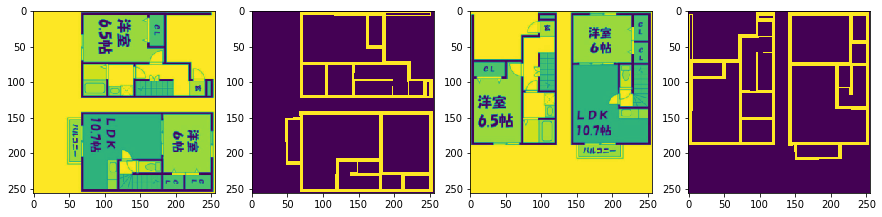

tensor([0.])


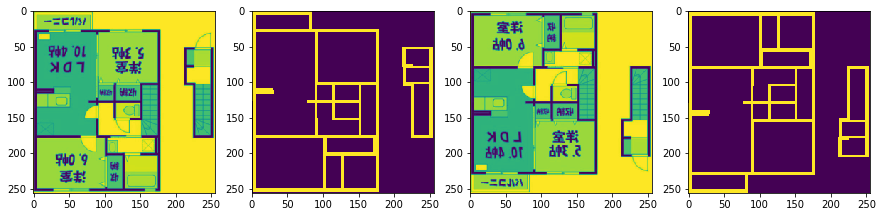

tensor([1.])


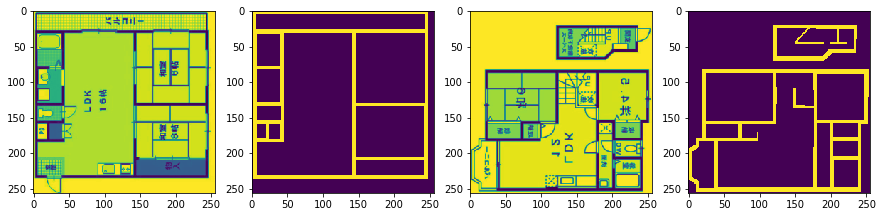

In [4]:
for i, batch in enumerate(train_dl):
    img1, label1, img2, label2, is_diff = batch
    for k in range(batch_size):
        print(is_diff[k])
        imshow4(img1[k], label1[k], img2[k], label2[k])
    break

### train & validation

In [5]:
model = SiameseNetwork().to(device)
criterion_unet = DiceLoss()
criterion_siamese = ContrastiveLoss()
optimizer = Adam(model.parameters(), lr=0.0005)

In [ ]:
unet_train_loss_history, unet_val_loss_history = [], []
sia_train_loss_history, sia_val_loss_history = [], []
unet_lowest_epoch_train_loss = unet_lowest_epoch_val_loss = float('inf')
sia_lowest_epoch_train_loss = sia_lowest_epoch_val_loss = float('inf')

for epoch in tqdm(range(num_epochs)):
    model.train()
    unet_epoch_train_loss = sia_epoch_train_loss = 0
    for i, batch in enumerate(train_dl):
        img1, label1, img2, label2, is_diff = batch
        img1, label1 = img1.to(device), label1.to(device)
        img2, label2 = img2.to(device), label2.to(device)
        is_diff = is_diff.to(device)
        
        optimizer.zero_grad()
        output_unet1, output_unet2, output1, output2 = model(img1, img2)
        
        # unet loss
        unet_batch_train_loss = criterion_unet(output_unet1, torch.squeeze(label1.long(), dim=1))
        unet_batch_train_loss += criterion_unet(output_unet2, torch.squeeze(label2.long(), dim=1))
        unet_epoch_train_loss += unet_batch_train_loss.item()
        
        # siamese loss
        sia_batch_train_loss = criterion_siamese(output1, output2, is_diff)
        sia_epoch_train_loss += sia_batch_train_loss.item()
        
        # optimize with total loss
        total_loss = unet_batch_train_loss + sia_batch_train_loss
        total_loss.backward()
        optimizer.step()
        
    unet_epoch_train_loss /= (i+1)
    sia_epoch_train_loss /= (i+1)
    if sia_epoch_train_loss < sia_lowest_epoch_train_loss:
        sia_lowest_epoch_train_loss = sia_epoch_train_loss
        torch.save(model.state_dict(), f'{checkpoint_dir}/best_train.pth')
    unet_train_loss_history += [unet_epoch_train_loss]
    sia_train_loss_history += [sia_epoch_train_loss]
    
    model.eval()
    with torch.no_grad():
        unet_epoch_val_loss = sia_epoch_val_loss = 0
        for i, batch in enumerate(val_dl):
            img1, label1, img2, label2, is_diff = batch
            img1, label1 = img1.to(device), label1.to(device)
            img2, label2 = img2.to(device), label2.to(device)
            is_diff = is_diff.to(device)
            
            output_unet1, output_unet2, output1, output2 = model(img1, img2)
            
            # unet loss
            unet_batch_val_loss = criterion_unet(output_unet1, torch.squeeze(label1.long(), dim=1))
            unet_batch_val_loss += criterion_unet(output_unet2, torch.squeeze(label2.long(), dim=1))
            unet_epoch_val_loss += unet_batch_val_loss.item()

            # siamese loss
            sia_batch_val_loss = criterion_siamese(output1, output2, is_diff)
            sia_epoch_val_loss += sia_batch_val_loss.item()
            
        unet_epoch_val_loss /= (i+1)
        sia_epoch_val_loss /= (i+1)
        if sia_epoch_val_loss < sia_lowest_epoch_val_loss:
            sia_lowest_epoch_val_loss = sia_epoch_val_loss
            torch.save(model.state_dict(), f'{checkpoint_dir}/best_val.pth')
        unet_val_loss_history.append(unet_epoch_val_loss)
        sia_val_loss_history.append(sia_epoch_val_loss)
        
    print(f'Epoch {epoch} training unet/sia loss is {unet_epoch_train_loss}/{sia_epoch_train_loss}, \
          validation unet/sia loss is {unet_epoch_val_loss}/{sia_epoch_val_loss}')      

Epoch 0 training unet/sia loss is 0.8937676864435771/1.2731057797586889,           validation unet/sia loss is 0.7228249632047884/0.5866828709840775
Epoch 1 training unet/sia loss is 0.5398016731030512/0.6303831298094154,           validation unet/sia loss is 0.40036488053473557/0.8943329003188064
Epoch 2 training unet/sia loss is 0.3188906364999469/0.3908675938936601,           validation unet/sia loss is 0.2596904778796615/0.28057776170669857
Epoch 3 training unet/sia loss is 0.23984285481193318/0.299903700469489,           validation unet/sia loss is 0.21646342550714812/0.3235140476670574
Epoch 4 training unet/sia loss is 0.2065254322166298/0.24971746719430188,           validation unet/sia loss is 0.188513350644798/0.2232255424376569
Epoch 5 training unet/sia loss is 0.18530038513097744/0.19826288018816296,           validation unet/sia loss is 0.18027465440558665/0.1717593486678714


In [ ]:
show_plot(train_loss_history, val_loss_history)

### test

In [ ]:
model = ResUNet().to(device)
model.load_state_dict(torch.load(f'{checkpoint_dir}/best_val.pth'))
test_dl = DataLoader(MadoriOutlineDS(test_file), batch_size=1, shuffle=False)

In [ ]:
model.eval()
test_results_0 = []
test_results_1 = []
with torch.no_grad():
    for i, batch in enumerate(test_dl):
        if i > 10: break
        img, label = batch
        img, label = img.to(device), label.to(device)
        pred = F.softmax(model(img), dim=1)
        
        img, label, pred = img.cpu(), label.cpu(), pred.cpu()
        
        ones = torch.ones((256, 256))
        zeros = torch.zeros((256, 256))
        
        imshow(img[0], label[0], torch.where(pred[0,1] > 0.5, ones, zeros))

### pair test

In [ ]:
model = ResUNet().to(device)
model.load_state_dict(torch.load(f'{checkpoint_dir}/best_val.pth'))
pair_test_dl = DataLoader(MadoriOutlineDS(pair_madori_file, pair_test=True), batch_size=1, shuffle=False)

In [ ]:
model.eval()
with torch.no_grad():
    for i, img in enumerate(pair_test_dl):
        pred = F.softmax(model(img.to(device)), dim=1)
        
        img, pred = img.cpu(), pred.cpu()
        
        ones = torch.ones((256, 256))
        zeros = torch.zeros((256, 256))
        
        imshow2(img[0], torch.where(pred[0,1] > 0.5, ones, zeros))